In [1]:
import os#Miscellaneous operating system interfaces
os.chdir(r'C:\\Users\\rtreichl\\allstate')  #working directory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb #xgboost

from sklearn.grid_search import RandomizedSearchCV

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import beta
from scipy.stats import expon

from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA

In [2]:
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [4]:
print(train.shape)
print(test.shape)

(188318, 132)
(125546, 131)


In [5]:
#set output to view more columns and rows
pd.set_option("display.max_columns",4000)
pd.set_option("display.max_rows",5000)

pd.options.display.max_seq_items = 10000

In [6]:
target = train['loss']
train = train.drop(['id','loss'],axis=1)
test_id=test['id']
test  = test.drop('id',axis=1)

print(train.shape)
print(test.shape)               

#length of train
num_train = len(train)

#combine train and test sets
df_all = pd.concat((train, test), axis=0, ignore_index=True)
print(df_all.shape)
del train
del test

(188318, 130)
(125546, 130)
(313864, 130)


In [7]:
# encode
ab_list = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9',
       'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17',
       'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25',
       'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33',
       'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41',
       'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49',
       'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57',
       'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65',
       'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72']
#  Encoding categorical features
# creating indicator variables (and leaving 1 out) will prove erroneous given the number of variables and anonimity

for f in ab_list:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(np.unique(list(df_all[f].values)))
    df_all[f] = lbl.transform(list(df_all[f].values))

In [8]:
#dummy
d_list = ['cat73','cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81',
       'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89',
       'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97',
       'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104',
       'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111',
       'cat112', 'cat113', 'cat114', 'cat115', 'cat116']

for dl in d_list:                           
    dummy_temp=[]
    dummy_temp=pd.get_dummies(df_all[dl],prefix=str(dl),prefix_sep='_')
    df_all=pd.concat([df_all,dummy_temp],axis=1)

df_all=df_all.drop(d_list,axis=1)   

In [9]:
# identify potential duplicate columns

dupecol = []
c = df_all.columns
for i in range(len(c)-1):
    v = df_all[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_all[c[j]].values):
            dupecol.append(c[j])
df_all=df_all.drop(dupecol,axis=1)

In [10]:
constant=[]

for col in df_all.columns:
    if df_all[col].std() == 0:
        constant.append(col)

df_all.drop(constant, axis=1, inplace=True)

In [11]:
#define train and test set from df_all
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]

std_scale = MinMaxScaler(feature_range=(-1, 1)).fit(df_train)
x_train_std = std_scale.transform(df_train)
x_test_std = std_scale.transform(df_test)

del df_all
del df_train
del df_test

In [12]:
################################
#    PCA
###############################

#pca
pca_estimator  = PCA(whiten=True)
x_train_pca = pca_estimator.fit_transform(x_train_std)
x_test_pca  = pca_estimator.transform(x_test_std)

C:\Users\rtreichl\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


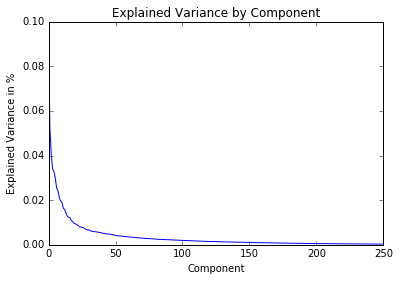

In [13]:
#Identify Number of components to model
ex_var=pca_estimator.explained_variance_ratio_[:250]
ex_var_all=pd.DataFrame(pca_estimator.explained_variance_ratio_)
plt.plot(ex_var)
plt.xlabel('Component')
plt.ylabel('Explained Variance in %')
plt.title('Explained Variance by Component')
plt.legend(loc='best')

In [15]:
import warnings
warnings.filterwarnings('ignore')



# build a extreme gradient booster regressor
xgb_params =  {'objective'   : 'reg:linear',
               'eval_metric' : 'mae', 
               'nthread'     : -1,
               'seed'        : 27,
               'silent'      : 0
              }


clf_xgb = xgb.XGBRegressor(xgb_params)
         
# use a full grid over all parameters
xgb_param_grid = {"max_depth"         : sp_randint(3, 40),
                  "learning_rate"     : uniform(0.01,0.3),
#                  "n_estimators"      : sp_randint(20, 50000),
                  "gamma"             : uniform(0.0,10.0),
                  "min_child_weight"  : expon(0, 50),
                  #"max_delta_step"    : 1
                  "subsample"         : beta(10, 1),
                  "colsample_bytree"  : beta(10, 1),
                  #"colsample_bylevel" :
                  "reg_alpha"         : expon(0, 50),
                  "reg_lambda"        : uniform(0.0,1.0),
                  "scale_pos_weight"  : uniform(1,3),
                 }

# run grid search
n_iter_search = 100

grid_search = RandomizedSearchCV(estimator=clf_xgb, param_distributions=xgb_param_grid,n_jobs=-1,
                                 scoring='mean_absolute_error',n_iter=n_iter_search)
grid_search.fit(x_train_pca[:,:250], target.ravel())

print(str(grid_search.best_estimator_)+"      grid_search.best_estimator_")
print(str(grid_search.best_score_)+"      grid_search.best_score_")

XGBRegressor(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.9372094088402632, gamma=1.5032557849778516,
       learning_rate=0.19078948741159998, max_delta_step=0, max_depth=8,
       min_child_weight=5.862596762894024, missing=None, n_estimators=100,
       nthread=-1, objective='reg:linear', reg_alpha=28.674865018539798,
       reg_lambda=0.36472541255932744, scale_pos_weight=1.8747397567175428,
       seed=0, silent=True, subsample=0.8364553606760016)      grid_search.best_estimator_
-1276.005178      grid_search.best_score_


In [20]:
xgb_params =  {'base_score':0.5,'colsample_bylevel':1,'colsample_bytree':0.5,'gamma':1.032557849778516,
               'learning_rate':0.01,'max_delta_step':0,'max_depth':12,
               'min_child_weight':1,'missing':None,'n_estimators':2500,
               'nthread':-1,'objective':'reg:linear','reg_alpha':1,
               'reg_lambda':0.36472541255932744,'scale_pos_weight':1.8747397567175428,
               'seed':0,'silent':True,'subsample':0.8364553606760016
              }

dtrain = xgb.DMatrix(x_train_pca[:,:250], label=target)
xgb_test_data  = xgb.DMatrix(x_test_pca[:,:250])
gbdt = xgb.train(xgb_params, dtrain)

y_pred_train=pd.DataFrame(gbdt.predict(dtrain),columns=['yhat'])
y_pred_test =pd.DataFrame(gbdt.predict(xgb_test_data),columns=['yhat'])

mean_ae_train = mean_absolute_error(target, y_pred_train['yhat'])
#mean_ae_test  = mean_absolute_error(y_test, y_pred_test['yhat'])

print(' train mse '+ str(mean_ae_train))
#print(' test mse ' + str(mse_test))


submission=pd.DataFrame(columns=['id','loss'])
submission['id']=test_id
submission['loss']=y_pred_test['yhat']
submission.to_csv('allstate_submission.csv',index=False)

 train mse 1246.20222731
